In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        Sigma_Z = np.diag(random(n))
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def is_close_to_zero(arr, etol):
    return np.allclose(arr, 0, atol=etol)

def matrix_B(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    B = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A) @ A.T @ inv_Sigma_Z_hat
    return B

def covariance_matrix_W(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    Sigma_W = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    return diagonalized_Sigma_Z

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err

def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    lambda_term = lamda * np.trace((np.identity(n) - A @ B) @ Sigma_Y @ ((np.identity(n) - A @ B).T) + A @ Sigma_W @ A.T)
    
    return regularizer - gamma * reconstruction + lambda_term

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('Optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('Matrix A:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nMatrix B:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nCovariance matrix of W:\n{}'.format(np.round(Sigma_W, 4)))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
    else:
        print('Vector a:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nVector b:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)[0]))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nVariance of W:\n{}'.format(np.round(Sigma_W, 4)[0][0]))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))        
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, lamda, flag, m, n, is_arr):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag)[1:1+m*n].reshape((m, n)), initial_inputs(flag)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag)[1:1+n*m].reshape((n, m)), initial_inputs(flag)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if is_arr == 0:
        if m > 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial matrix B:')
            print(np.round(B.reshape((m, n)), 4))
            print('\nInitial covariance matrix of W:')
            print(np.round(Sigma_W, 4))
        elif m == 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial vector b:')
            print(np.round(B.reshape((m, n)), 4)[0])
            print('\nInitial variance of W:')
            print(np.round(Sigma_W, 4)[0][0])
        elif m > 1 and flag == 1:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial matrix A:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))
        else:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial vector a:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))    
    
        # Print results
        if flag == 0:
            # Compute optimal solution given encoder inputs
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
    
            # Extract length of arrays for cost function and mutual information of encoder and decoder
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            # Plot values of cost function and mutual information against iterations
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)  
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
        
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)
    else:
        if flag == 0:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_arr):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 

    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break                       

        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
          
        if is_arr == 0 and i == MAX_ITERS - 1 and recon_err > MAX_RECON_ERR:
            print(colored('\nMax iterations was reached!', 'red', attrs=['bold']))
            print('There is NO solutions that has reconstruction error statisfying the tolerance error = {}.\n'.format(MAX_RECON_ERR))
            
        return sol
    
    except Exception as e:
        if is_arr == 0:
            print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

## I. Inputs

In [6]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: n = 3 and m = 2
3. Tolerable error: TOL_ERR = 1e-8
4. Reconstruction error tolerance: MAX_RECON_ERR = 0.05
5. A nxn positive definite matrix Sigma_Y
6. An array of gamma = [0.98, 1.02] with step size = 0.01
7. An array of lambda = [-0.02, 0.02] with step size = 0.01
"""

MAX_ITERS = 10000
n, m = 3, 2
TOL_ERR = 1e-8
MAX_RECON_ERR = 0.05

Sigma_Y = np.array([[1, 0.18, 0.12],
                   [0.18, 1, 0.06],
                   [0.12, 0.06, 1]])
print(colored('Covariance matrix of Y:', 'blue', attrs=['bold']))
print(np.round(Sigma_Y, 4))

gamma_arr = np.round(np.arange(0.98, 1.02, 0.01), 2)
print(colored('\nAn array of gamma:', 'blue', attrs=['bold']))
print('{}'.format(gamma_arr))

lambda_arr = np.round(np.arange(-0.02, 0.03, 0.01), 2)
print(colored('\nAn array of lambda:', 'blue', attrs=['bold']))
print('{}'.format(lambda_arr))

Covariance matrix of Y:
[[1.   0.18 0.12]
 [0.18 1.   0.06]
 [0.12 0.06 1.  ]]

An array of gamma:
[0.98 0.99 1.   1.01 1.02]

An array of lambda:
[-0.02 -0.01  0.    0.01  0.02]


## II. Numerical results

In [7]:
# Constants
MAX_SOLS = 10
is_array = 1
flag = 0
case_num = 1

# Initiate arrays
min_recon_err_arr = []
min_en_mi_arr = []
min_de_mi_arr = []
all_recon_mi_arr = []
satisfied_recon_mi_arr = []
satisfied_gamma_lambda_arr = []

# Iteration step
for i in range(0, len(gamma_arr)):
    gamma = gamma_arr[i]
    for j in range(0, len(lambda_arr)):
        lamda = lambda_arr[j]
        
        min_recon_err, min_en_mi, min_de_mi, min_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
        
        first_iter = 1
        for num_sols in range(0, MAX_SOLS):
            current_recon_err, current_en_mi, current_de_mi, current_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
    
            # Check for unique optimal solutions for each (gamma, lambda) pair
            if first_iter == 1:
                if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - min_opt_sol[:2*n*m+n*n+m*m], 1e-6):
                    is_unique = 1
                    unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                else:
                    is_unique = 0
                first_iter = 0
            else:
                if is_unique == 1:
                    if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - unique_opt_sol, 1e-6):
                        unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                    else:
                        is_unique = 0
    
            # Return the solution with smallest reconstruction error
            if current_recon_err < min_recon_err:
                min_recon_err = current_recon_err
                min_en_mi = current_en_mi
                min_de_mi = current_de_mi
                min_opt_sol = current_opt_sol
                
        min_recon_err_arr = np.concatenate((min_recon_err_arr, [min_recon_err]))
        min_en_mi_arr = np.concatenate((min_en_mi_arr, [min_en_mi]))
        min_de_mi_arr = np.concatenate((min_de_mi_arr, [min_de_mi]))
        all_recon_mi_arr = np.concatenate((all_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
        print(colored('\nCase {}:'.format(case_num), 'blue', attrs=['bold']))
        case_num += 1
        
        if min_recon_err > MAX_RECON_ERR:
            print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that EXCEEDS the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
        else:
            print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that SATISFIES the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            
            satisfied_gamma_lambda_arr = np.concatenate((satisfied_gamma_lambda_arr, [gamma, lamda]))
            satisfied_recon_mi_arr = np.concatenate((satisfied_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
        if is_unique == 1:
            print(colored('The optimal solution is unique!\n', 'blue', attrs=['bold']))
        else:
            print(colored('The optimal solution is NOT unique!\n', 'red', attrs=['bold']))
        
        print_optimal_solution(min_opt_sol, m)


Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0475 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0299  0.4125]
 [-0.0239  0.33  ]
 [-0.0152  0.2097]]

Matrix B:
[[-0.0252 -0.0187 -0.0111]
 [ 0.3477  0.2583  0.1525]]

Covariance matrix of Z:
[[0.8289 0.     0.    ]
 [0.     0.8905 0.    ]
 [0.     0.     0.9558]]

Covariance matrix of W:
[[0.9986 0.0189]
 [0.0189 0.7393]]

Minimum value of the cost function:
4.0992

Mutual information of the encoder:
0.1519

Mutual information of the decoder:
0.1594

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[1.     0.1368 0.087 ]
 [0.1368 1.     0.0696]
 [0.087  0.0696 1.    ]]

Reconstruction error:
0.0475

Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.036 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[0.1536 0.4175]
 [0.1171 0.3183]
 [0.074

C:\Users\mhvu1\AppData\Local\Temp\ipykernel_33064\1079668157.py:53: RuntimeWarning: divide by zero encountered in log
  regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
C:\Users\mhvu1\AppData\Local\Temp\ipykernel_33064\1079668157.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))



Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.0055 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[0.302  0.4844]
 [0.1634 0.2621]
 [0.108  0.1733]]

Matrix B:
[[0.274  0.1099 0.0685]
 [0.4395 0.1763 0.11  ]]

Covariance matrix of Z:
[[0.6741 0.     0.    ]
 [0.     0.9046 0.    ]
 [0.     0.     0.9583]]

Covariance matrix of W:
[[ 0.8919 -0.1734]
 [-0.1734  0.7218]]

Minimum value of the cost function:
4.2469

Mutual information of the encoder:
0.2441

Mutual information of the decoder:
0.245

Value of Sigma_X:
[[ 1.  0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[1.     0.1763 0.1166]
 [0.1763 1.     0.0631]
 [0.1166 0.0631 1.    ]]

Reconstruction error:
0.0055

Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.0044 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0939  0.1879]
 [ 0.8445  0.5309]
 [-0.4793  

### 1. All cases

In [8]:
def format_results(number_arr):
    formatted_numbers = []
    for num in number_arr:
        if num == 0:
            formatted_numbers.append("{:.0f}".format(num))
        else:
            formatted_numbers.append("{:.4f}".format(num))
    return [float(x) for x in formatted_numbers]

In [9]:
"""
Extract values of reconstruction error, MI of encoder, and MI of decoder from every 3 elements in all_recon_mi_arr
"""

all_recon_err = format_results(all_recon_mi_arr[::3])
all_en_mi = format_results(all_recon_mi_arr[1::3])
all_de_mi = format_results(all_recon_mi_arr[2::3])

print(colored('\nArray of all reconstruction errors:', 'blue', attrs=['bold']))
print(all_recon_err)

print(colored('\nArray of all mutual information of encoder:', 'blue', attrs=['bold']))
print(all_en_mi)

print(colored('\nArray of all mutual information of decoder:', 'blue', attrs=['bold']))
print(all_de_mi)


Array of all reconstruction errors:
[0.0475, 0.036, 0.0245, 0.0042, 0.0019, 0.0404, 0.0286, 0.0138, 0.0009, 0.0009, 0.0329, 0.0197, 0.0, 0.0001, 0.0001, 0.0243, 0.0055, 0.0044, 0.0044, 0.0045, 0.0116, 0.0086, 0.0087, 0.0088, 0.0089]

Array of all mutual information of encoder:
[0.1519, 0.1716, 0.1932, 0.2456, 0.67, 0.1637, 0.1851, 0.2159, 0.6701, 1.3628, 0.1768, 0.2029, 0.3024, 4.5582, 5.2494, 0.1933, 0.2441, 49.063, 50.3136, 50.8796, 0.2245, 95.8355, 97.5335, 98.6923, 99.5084]

Array of all mutual information of decoder:
[0.1594, 0.1771, 0.1965, 0.2463, 0.6697, 0.1701, 0.1893, 0.2177, 0.67, 1.3626, 0.182, 0.2056, 0.3024, 4.5579, 5.2491, 0.1969, 0.245, 49.0481, 50.2986, 50.8646, 0.2264, 95.8059, 97.5038, 98.6625, 99.4785]


### 2. Satisfied cases: The reconstructed error is limited to a maximum of 5%

In [10]:
"""
Extract values of 
1. gamma and lambda from every 2 elements in satisfied_gamma_lambda_arr
2. reconstruction error, MI of encoder, and MI of decoder from every 3 elements in satisfied_recon_mi_arr
"""
satisfied_gamma = satisfied_gamma_lambda_arr[::2]
satisfied_lambda = satisfied_gamma_lambda_arr[1::2]

satisfied_recon_err = format_results(satisfied_recon_mi_arr[::3])
satisfied_en_mi = format_results(satisfied_recon_mi_arr[1::3])
satisfied_de_mi = format_results(satisfied_recon_mi_arr[2::3])

print(colored('\nArray of satisfied values of gamma:', 'blue', attrs=['bold']))
print(satisfied_gamma)

print(colored('\nArray of satisfied values of lambda:', 'blue', attrs=['bold']))
print(satisfied_lambda)

print(colored('\nArray of satisfied reconstruction errors:', 'blue', attrs=['bold']))
print(satisfied_recon_err)

print(colored('\nArray of satisfied mutual information of encoder:', 'blue', attrs=['bold']))
print(satisfied_en_mi)

print(colored('\nArray of satisfied mutual information of decoder:', 'blue', attrs=['bold']))
print(satisfied_de_mi)


Array of satisfied values of gamma:
[0.98 0.98 0.98 0.98 0.98 0.99 0.99 0.99 0.99 0.99 1.   1.   1.   1.
 1.   1.01 1.01 1.01 1.01 1.01 1.02 1.02 1.02 1.02 1.02]

Array of satisfied values of lambda:
[-0.02 -0.01  0.    0.01  0.02 -0.02 -0.01  0.    0.01  0.02 -0.02 -0.01
  0.    0.01  0.02 -0.02 -0.01  0.    0.01  0.02 -0.02 -0.01  0.    0.01
  0.02]

Array of satisfied reconstruction errors:
[0.0475, 0.036, 0.0245, 0.0042, 0.0019, 0.0404, 0.0286, 0.0138, 0.0009, 0.0009, 0.0329, 0.0197, 0.0, 0.0001, 0.0001, 0.0243, 0.0055, 0.0044, 0.0044, 0.0045, 0.0116, 0.0086, 0.0087, 0.0088, 0.0089]

Array of satisfied mutual information of encoder:
[0.1519, 0.1716, 0.1932, 0.2456, 0.67, 0.1637, 0.1851, 0.2159, 0.6701, 1.3628, 0.1768, 0.2029, 0.3024, 4.5582, 5.2494, 0.1933, 0.2441, 49.063, 50.3136, 50.8796, 0.2245, 95.8355, 97.5335, 98.6923, 99.5084]

Array of satisfied mutual information of decoder:
[0.1594, 0.1771, 0.1965, 0.2463, 0.6697, 0.1701, 0.1893, 0.2177, 0.67, 1.3626, 0.182, 0.2056, 0.30

## III. Plots

In [11]:
'''
3 plots used to analyze data:
1. 3D plot of mutual information of encoder and decoder w.r.t. (gamma, lambda) pair
2. Scatter plot of mutual information of encoder and decoder w.r.t. reconstruction error for each (gamma, lambda) pair
3. Boxplot of mutual information of encoder and decoder
'''

def plot_mutual_info_gamma_lambda_3d(x, y, z1, z2):
    # Create a colormap
    colors1 = z1
    colors2 = z2
    cmap1 = plt.cm.get_cmap('Blues_r')
    cmap2 = plt.cm.get_cmap('Reds_r')
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.w_xaxis.set_pane_color((0.95, 0.97, 1.0, 1.0)) 
    ax.w_yaxis.set_pane_color((0.95, 0.97, 1.0, 1.0)) 
    ax.w_zaxis.set_pane_color((0.93, 0.96, 1.0, 1.0))
 
    sc1 = ax.scatter(x, y, z1, c=colors1, cmap=cmap1, marker='^', s=20, label='Encoder', vmin=min(z1), vmax=max(z1))
    sc2 = ax.scatter(x, y, z2, c=colors2, cmap=cmap2, marker='o', s=20, label='Decoder', vmin=min(z2), vmax=max(z2))

    # Add distance annotations for each point of mutual information of decoder
    for i in range(len(x)):
        z2_dist = z2[i]
        ax.text(x[i], y[i], z2[i] + 2, f'{z2_dist:.2f}', ha='center', fontsize=10)
                     
    # Draw dashed lines from each point to the surface base
    for i in range(len(x)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [0, z1[i]], color='blue', linestyle='--', linewidth=1)
        ax.plot([x[i], x[i]], [y[i], y[i]], [0, z2[i]], color='red', linestyle='--', linewidth=1)      
        
    ax.set_xlim3d(min(x), max(x))
    ax.set_xticks(np.unique(np.round(x, 2)))
    ax.set_ylim3d(min(y), max(y))
    ax.set_yticks(np.unique(np.round(y, 2)))
    ax.set_zlim3d(min(min(z1), min(z2)), max(max(z1), max(z2)))
    
    ax.set_xlabel('lambda', fontsize=10)
    ax.set_ylabel('gamma', fontsize=10)
    ax.set_zlabel('Mutual Information', fontsize=10)

    cbar1 = plt.colorbar(sc1, shrink=0.6, aspect=30, pad=0.07)
    cbar1.ax.set_ylabel('Mutual Information of Encoder', rotation=270, labelpad=15, fontsize=10)
    cbar2 = plt.colorbar(sc2, shrink=0.6, aspect=30, pad=0.1)
    cbar2.ax.set_ylabel('Mutual Information of Decoder', rotation=270, labelpad=15, fontsize=10)

    ax.legend()
    ax.view_init(elev=25, azim=-45)
    plt.show()
    
def plot_mutual_info_recon(x, y1, y2, x_annot, y_annot):
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.scatter(x, y1, color='black', marker='^', s=20, label='Encoder')
    plt.scatter([], [], color='red', marker='o', s=10, label='Decoder')
    
    # Add annotations that specify the (gamma, lambda) pair corresponding to each point
    texts = []
    for i, (x_val, y_val) in enumerate(zip(x, y2)):
        plt.scatter(x_val, y_val, color='red', marker='o', s=10)
        texts.append(ax.text(x_val, y_val, f"({x_annot[i]}, {y_annot[i]})", ha='center', va='bottom'))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.xlabel('Reconstruction Error', fontsize=10)
    plt.ylabel('Mutual Information', fontsize=10)
    
    plt.legend()
    plt.show()
    
def mutual_info_boxplot(x, y1, y2, ax):
    # Compute mean, median, and std of data
    mean_y1, median_y1, std_y1 = np.mean(y1), np.median(y1), np.std(y1)
    mean_y2, median_y2, std_y2 = np.mean(y2), np.median(y2), np.std(y2)

    # Create the boxplot
    bp1 = ax.boxplot(y1, positions=[1], widths=0.6, showfliers=True, patch_artist=True,
                     boxprops=dict(facecolor='C0', color='C0'), medianprops=dict(color='red'))
    bp2 = ax.boxplot(y2, positions=[2], widths=0.6, showfliers=True, patch_artist=True,
                     boxprops=dict(facecolor='C1', color='C1'), medianprops=dict(color='red'))
    ax.set_xticklabels(x, fontsize=10)

    # Add outlier points
    for element in ['fliers']:
        plt.setp(bp1[element], marker='o', markersize=5, markeredgecolor='C0', alpha=0.5)
        plt.setp(bp2[element], marker='o', markersize=5, markeredgecolor='C1', alpha=0.5)

    # Add legend
    bp1_mean_median_std = f"Mean: {mean_y1:.2f}\nMedian: {median_y1:.2f}\nStd: {std_y1:.2f}"
    bp2_mean_median_std = f"Mean: {mean_y2:.2f}\nMedian: {median_y2:.2f}\nStd: {std_y2:.2f}"
    legend_elements = [Patch(facecolor='C0', edgecolor='C0', label=bp1_mean_median_std),
                       Patch(facecolor='C1', edgecolor='C1', label=bp2_mean_median_std)]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

def plot_mutual_info(y1, z1, y2, z2, y3, z3):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # Plot 3 boxplots side by side
    mutual_info_boxplot(['Encoder', 'Decoder'], y1, z1, ax1)
    mutual_info_boxplot(['Encoder', 'Decoder'], y2, z2, ax2)
    mutual_info_boxplot(['Encoder', 'Decoder'], y3, z3, ax3)
    
    ax1.set_ylabel('Mutual Information', fontsize=10)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(wspace=0.3)
    plt.show()

In [12]:
def get_length_gamma_lt_one(arr):
    return sum(1 for num in arr if num < 1)

def get_length_gamma_eq_one(arr):
    return sum(1 for num in arr if num == 1)

def get_length_gamma_gt_one(arr):
    return sum(1 for num in arr if num > 1)

### 1. 3D plot of mutual information w.r.t. (gamma, lambda) pair

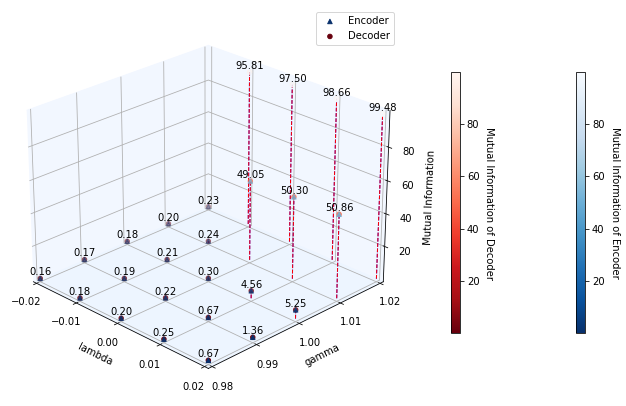

In [13]:
plot_mutual_info_gamma_lambda_3d(satisfied_lambda, satisfied_gamma, satisfied_en_mi, satisfied_de_mi)

### 2. Scatter plot of mutual information w.r.t. reconstruction error for each (gamma, lambda) pair

#### a. gamma < 1:

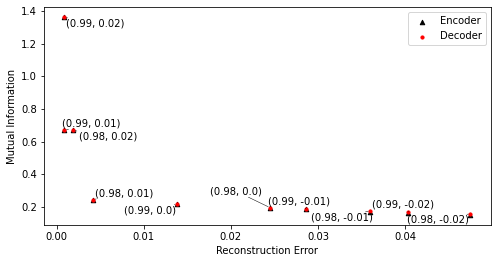

In [14]:
length_lt_one = get_length_gamma_lt_one(satisfied_gamma)

recon_err_gamma_lt_one = satisfied_recon_err[:length_lt_one]
en_mi_gamma_lt_one = satisfied_en_mi[:length_lt_one]
de_mi_gamma_lt_one = satisfied_de_mi[:length_lt_one]
gamma_arr_lt_one = satisfied_gamma[:length_lt_one]
lambda_arr_gamma_lt_one = satisfied_lambda[:length_lt_one]

plot_mutual_info_recon(recon_err_gamma_lt_one, en_mi_gamma_lt_one, de_mi_gamma_lt_one, gamma_arr_lt_one, lambda_arr_gamma_lt_one)

#### b. gamma = 1:

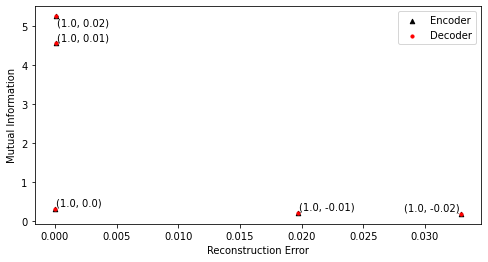

In [15]:
length_eq_one = get_length_gamma_eq_one(satisfied_gamma)

recon_err_gamma_eq_one = satisfied_recon_err[length_lt_one : length_lt_one+length_eq_one]
en_mi_gamma_eq_one = satisfied_en_mi[length_lt_one : length_lt_one+length_eq_one]
de_mi_gamma_eq_one = satisfied_de_mi[length_lt_one : length_lt_one+length_eq_one]
gamma_arr_eq_one = satisfied_gamma[length_lt_one : length_lt_one+length_eq_one]
lambda_arr_gamma_eq_one = satisfied_lambda[length_lt_one : length_lt_one+length_eq_one] 

plot_mutual_info_recon(recon_err_gamma_eq_one, en_mi_gamma_eq_one, de_mi_gamma_eq_one, gamma_arr_eq_one, lambda_arr_gamma_eq_one)

#### c. gamma > 1

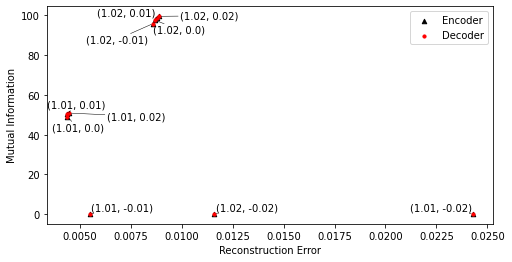

In [16]:
length_gt_one = get_length_gamma_gt_one(satisfied_gamma)

recon_err_gamma_gt_one = satisfied_recon_err[-length_gt_one:]
en_mi_gamma_gt_one = satisfied_en_mi[-length_gt_one:]
de_mi_gamma_gt_one = satisfied_de_mi[-length_gt_one:]
gamma_arr_gt_one = satisfied_gamma[-length_gt_one:]
lambda_arr_gamma_gt_one = satisfied_lambda[-length_gt_one:] 

plot_mutual_info_recon(recon_err_gamma_gt_one, en_mi_gamma_gt_one, de_mi_gamma_gt_one, gamma_arr_gt_one, lambda_arr_gamma_gt_one)

### 3. Boxplot of mutual information

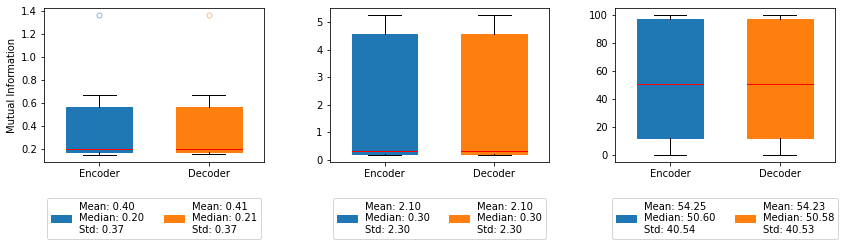

In [17]:
plot_mutual_info(en_mi_gamma_lt_one, de_mi_gamma_lt_one, en_mi_gamma_eq_one, de_mi_gamma_eq_one, en_mi_gamma_gt_one, de_mi_gamma_gt_one)